# Titanic dataset predictions

-> https://www.kaggle.com/competitions/titanic/overview can be used to see an overview of the data

## Todo

- read the overview and define research questions

- load in the data

- perform at least 3 examples of EDA (Visualisations that are relivant to the problem)

- train tune and apply a machine learning model 

- share it with ross :)

# Challenge 

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

Quesitons I would like to answer

Who will survive?
What factors are the strongest indicators of survival? (Class - Sex - Age?)

*see below for an example of an output that could be submitted* 


# Importing Libraries

In [1]:
#A range of python packages
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn import preprocessing
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve,accuracy_score,\
precision_score, recall_score, f1_score, mean_squared_error
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline
warnings.filterwarnings('ignore')

### Custom functions

from data_cleaning import drop_df_cols, visualise_missing_values

In [2]:
example_output_df = pd.read_csv('titanic/gender_submission.csv')
example_output_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


# Loading in the data

In [3]:
#Loading in the data
train_df = pd.read_csv('titanic/train.csv')
test_df = pd.read_csv('titanic/test.csv') # does not contain a 'survived' column
train_df.head()
# sibsp == number of siblings / spouses aboard the Titanic
# Parch == number of parents / children aboard 


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Steps to clean the data
- Dropping Columns we don't need
- Finding missing data
- Create Age groups - Young Middle and Old

In [4]:
drop_df_cols(train_df, "Name", "Ticket", 'Cabin',"Embarked")
drop_df_cols(test_df, "Name", "Ticket", 'Cabin',"Embarked")
train_df['Sex'].replace(['female','male'],[0,1],inplace=True)
test_df['Sex'].replace(['female','male'],[0,1],inplace=True)
test_df

----- Droped ['Name', 'Ticket', 'Cabin', 'Embarked']
----- Droped ['Name', 'Ticket', 'Cabin', 'Embarked']


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,892,3,1,34.5,0,0,7.8292
1,893,3,0,47.0,1,0,7.0000
2,894,2,1,62.0,0,0,9.6875
3,895,3,1,27.0,0,0,8.6625
4,896,3,0,22.0,1,1,12.2875
...,...,...,...,...,...,...,...
413,1305,3,1,NaN,0,0,8.0500
414,1306,1,0,39.0,0,0,108.9000
415,1307,3,1,38.5,0,0,7.2500
416,1308,3,1,NaN,0,0,8.0500


In [5]:
# Dataset stats
train_df.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200


# Visualisation of missing data

- you can use a library for this I am sure

Blue is missing, Red is not missing
number of NaN cols:  PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
dtype: int64


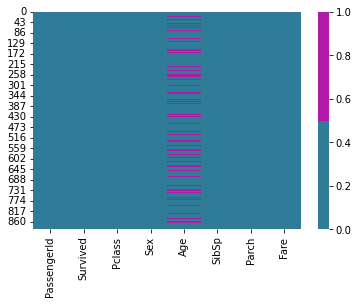

In [6]:
visualise_missing_values(train_df)

Blue is missing, Red is not missing
number of NaN cols:  PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
dtype: int64


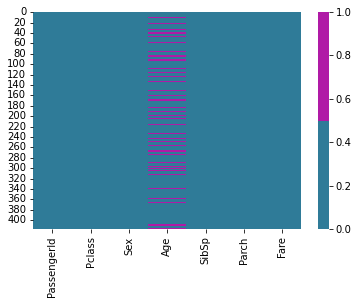

In [7]:
visualise_missing_values(test_df)

In [8]:
#removing NaNs
test_df = test_df[test_df['Age'].notna()]
train_df = train_df[train_df['Age'].notna()]
train_df = train_df[train_df['Fare'].notna()]

# Creating age groups (for visualisation)

In [9]:
# Creating Age groups
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
test_df['AgeBand'] = pd.cut(test_df['Age'], 5)
train_df['AgeBand'].value_counts()

(16.336, 32.252]    346
(32.252, 48.168]    188
(0.34, 16.336]      100
(48.168, 64.084]     69
(64.084, 80.0]       11
Name: AgeBand, dtype: int64

Text(0.5, 0.98, 'Survial hue by Age')

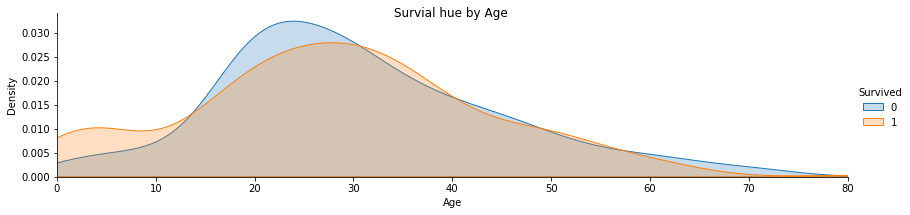

In [10]:
facet = sns.FacetGrid(train_df, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train_df['Age'].max()))
facet.add_legend()
facet.fig.suptitle('Survial hue by Age')

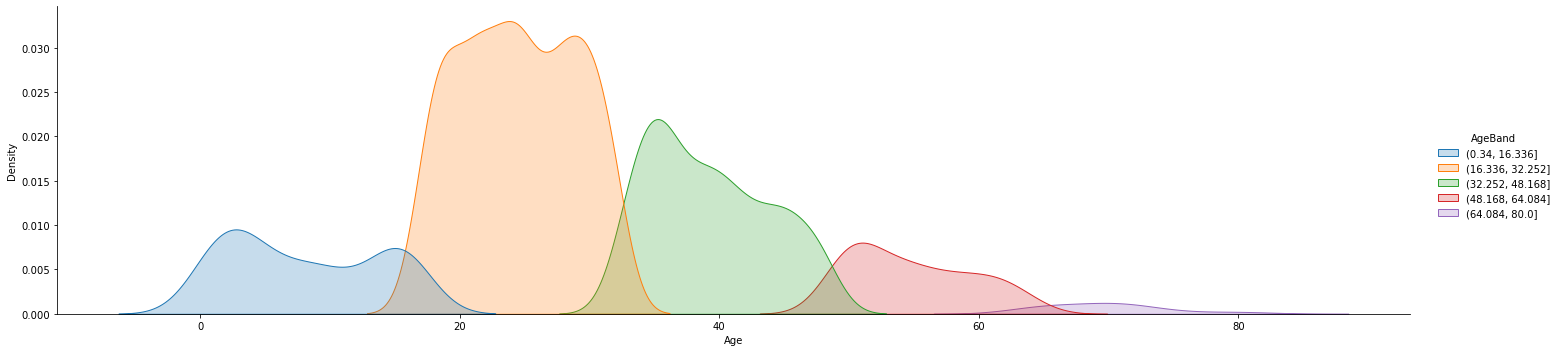

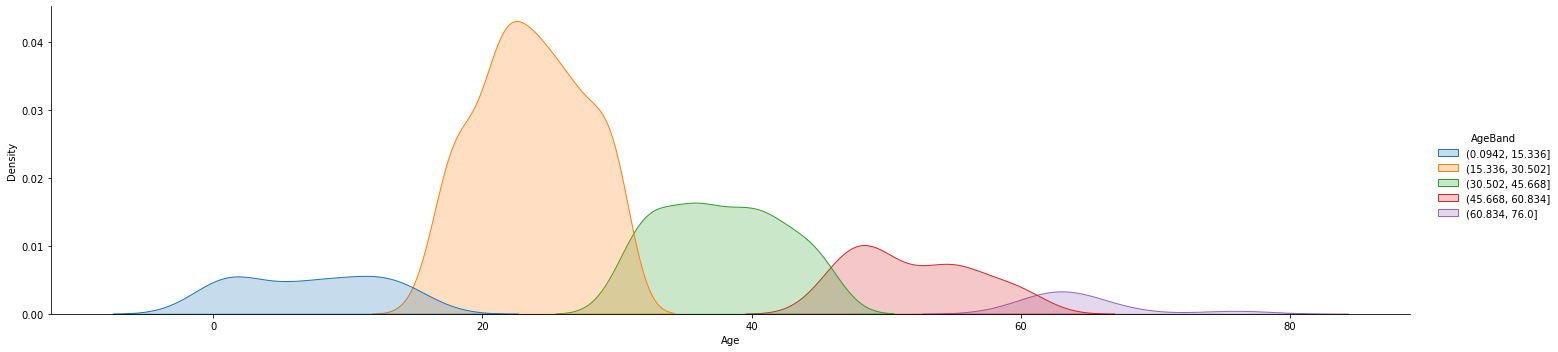

In [11]:
# Range of ages in both testing and training datasets
sns.displot(train_df, x="Age", hue='AgeBand', aspect= 4, kind="kde", fill=True)
sns.displot(test_df, x="Age", hue='AgeBand', aspect= 4, kind="kde", fill=True)

In [12]:
#survival based on age range (maybe add in plot for this later)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.34, 16.336]",0.550000
1,"(16.336, 32.252]",0.369942
2,"(32.252, 48.168]",0.404255
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


In [11]:
#Creating Age Ranges (Not the best way probably) example found in here -> https://www.kaggle.com/code/startupsci/titanic-data-science-solutions
train_df.loc[ train_df['Age'] <= 16, 'Age'] = 0
train_df.loc[(train_df['Age'] > 16) & (train_df['Age'] <= 32), 'Age'] = 1
train_df.loc[(train_df['Age'] > 32) & (train_df['Age'] <= 48), 'Age'] = 2
train_df.loc[(train_df['Age'] > 48) & (train_df['Age'] <= 64), 'Age'] = 3
train_df.loc[ train_df['Age'] > 65, 'Age'] = 4
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,AgeBand
0,1,0,3,1,1.0,1,0,7.2500,"(16.336, 32.252]"
1,2,1,1,0,2.0,1,0,71.2833,"(32.252, 48.168]"
2,3,1,3,0,1.0,0,0,7.9250,"(16.336, 32.252]"
3,4,1,1,0,2.0,1,0,53.1000,"(32.252, 48.168]"
4,5,0,3,1,2.0,0,0,8.0500,"(32.252, 48.168]"


In [12]:
#Creating Age Ranges (Not the best way probably) example found in here -> https://www.kaggle.com/code/startupsci/titanic-data-science-solutions
test_df.loc[ test_df['Age'] <= 16, 'Age'] = 0
test_df.loc[(test_df['Age'] > 16) & (test_df['Age'] <= 32), 'Age'] = 1
test_df.loc[(test_df['Age'] > 32) & (test_df['Age'] <= 48), 'Age'] = 2
test_df.loc[(test_df['Age'] > 48) & (test_df['Age'] <= 64), 'Age'] = 3
test_df.loc[ test_df['Age'] > 65, 'Age'] = 4
test_df['Age'].describe()

count    332.000000
mean       1.382530
std        0.837957
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: Age, dtype: float64

# Further Visualisations

- Survival based on sex
- Survival based on class
- Survival based on age
- Survival based on if they are a parent/child

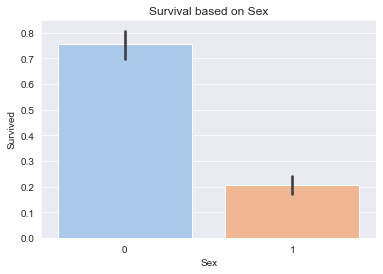

In [13]:
sns.set_palette("pastel")
sns.set_style("darkgrid")
sns.barplot(x = "Sex", y = "Survived", data = train_df).set_title('Survival based on Sex')
plt.show()

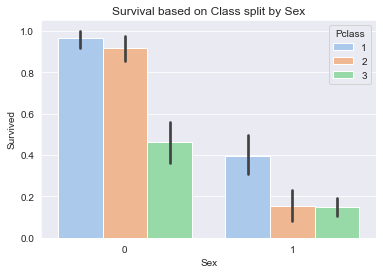

In [57]:
sns.barplot(x = "Sex", y = "Survived", hue = "Pclass", data = train_df).set_title('Survival based on Class split by Sex')
plt.show()

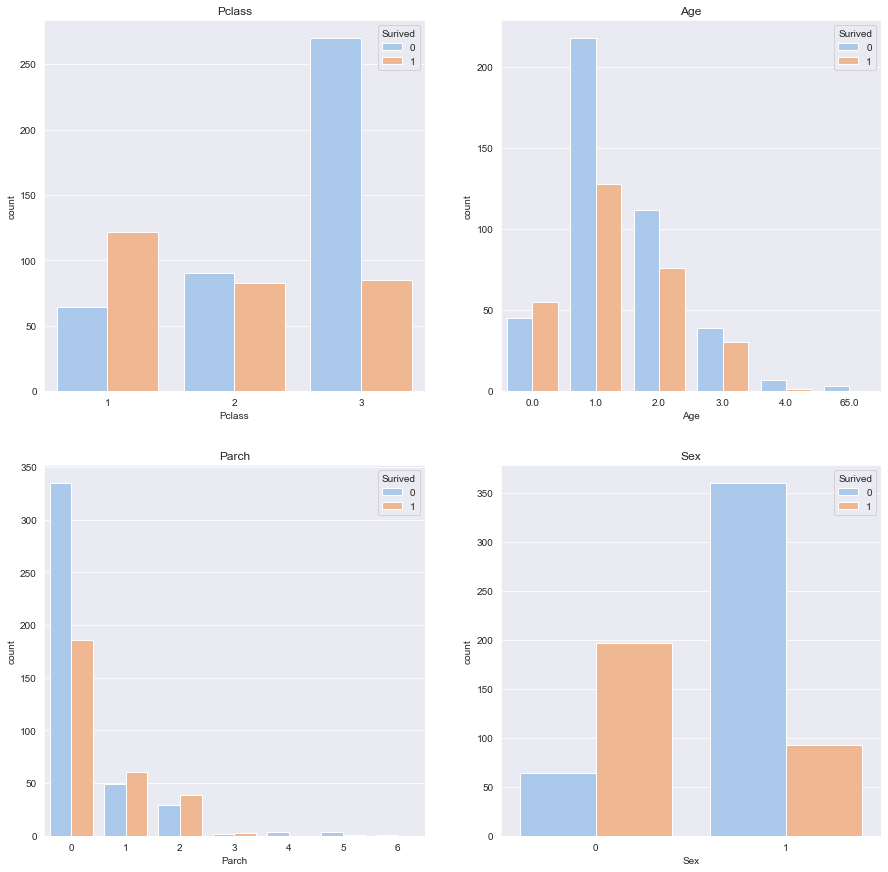

In [17]:
cols = ['Pclass', 'Age', 'Parch','Sex']
n_rows = 2
n_cols = 2
# create a subplot for the different cols
fig, axes = plt.subplots(n_rows, n_cols, figsize = (15,15))

for r in range(0, n_rows):
    for c in range(0, n_cols):
        i = r*n_cols + c #index to go through the number of cols
        ax = axes[r][c] #define each position of the subplot
        sns.countplot(train_df[cols[i]], hue=train_df['Survived'], ax = ax)
        ax.set_title(cols[i])
        ax.legend(title='Surived', loc='upper right')
plt.show()

<AxesSubplot:xlabel='Sex'>

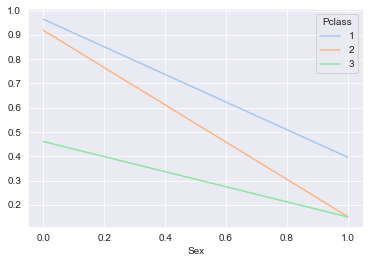

In [59]:
#visual representation of the chance of death based on class
train_df.pivot_table('Survived', index='Sex', columns='Pclass').plot()

# Splitting the data

## Without validation set

- Standard train test split (I could maybe use Standardised variable names)
- Define a function that fits a range of models
    - logistic regression
    - k-nearest neighbors
    - Support vector machines (Linear Kernal)
    - Support vector machines (Radial Basis Function Kernal) I should read more into this
    - Decision trees
    - Random forests
    

## The training accuracy score of each model is then printed

*The models are then put into a list which enables you to call any of the models using the appropriate index - For example model[0] would be the logistic regression model *

In [14]:
X = train_df.iloc[:, 2:7].values
Y_traget = train_df.iloc[:, 1].values
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_traget, 
                                                    train_size=0.75, random_state=400)
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(535, 5) (179, 5) (535,) (179,)


In [15]:
def models(X_train, Y_train):
    
    #logistic regression
    from sklearn.linear_model import LogisticRegression
    log = LogisticRegression(random_state=400)
    log.fit(X_train,Y_train)
    
    #KNN
    from sklearn.neighbors import KNeighborsClassifier
    KNN = KNeighborsClassifier(n_neighbors=5, metric = 'minkowski', p = 2)
    KNN.fit(X_train,Y_train)
    
    #support vector classifiers
    from sklearn.svm import SVC
    SVC_lin = SVC(kernel='linear', random_state=400)
    SVC_lin.fit(X_train,Y_train)
    
    SVC_RBF = SVC(kernel='rbf', random_state=400)
    SVC_RBF.fit(X_train,Y_train)
    
    #decision tree
    from sklearn.tree import DecisionTreeClassifier
    tree = DecisionTreeClassifier(criterion='entropy', random_state=400)
    tree.fit(X_train,Y_train)
    
    #Random Forest
    from sklearn.ensemble import RandomForestClassifier
    forest = RandomForestClassifier(n_estimators= 10, criterion='entropy', random_state=400)
    forest.fit(X_train,Y_train)
    
    # print accuracy
    
    print('[0]Logistic regression accuracy: ', log.score(X_train, Y_train))
    print('[1]KNN regression accuracy: ', KNN.score(X_train, Y_train))
    print('[2]SVC_lin regression accuracy: ', SVC_lin.score(X_train, Y_train))
    print('[3]SVC_RBF regression accuracy: ', SVC_RBF.score(X_train, Y_train))
    print('[4]Decision tree regression accuracy: ', tree.score(X_train, Y_train))
    print('[5]Random Forest regression accuracy: ', forest.score(X_train, Y_train))
    return log, KNN, SVC_lin, SVC_RBF, tree, forest



In [16]:
models = models(X_train,Y_train)

[0]Logistic regression accuracy:  0.7831775700934579
[1]KNN regression accuracy:  0.8186915887850468
[2]SVC_lin regression accuracy:  0.7757009345794392
[3]SVC_RBF regression accuracy:  0.7831775700934579
[4]Decision tree regression accuracy:  0.8542056074766355
[5]Random Forest regression accuracy:  0.8504672897196262


# Cross Validation Score 

##  Getting the cross validation score for a few of the models 

*This can be repeated for any of the models in the model list *

In [17]:
fold = ['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5',
        'Fold 6','Fold 7','Fold 8','Fold 9','Fold 10']
train_score_df = pd.DataFrame()
train_score_df['K Folds'] = fold
for i, model in enumerate(models):
    train_scores = cross_val_score(model, X_train, Y_train, scoring='accuracy', cv=10)
    train_score_df[i]=train_scores    

train_score_df.rename(columns={0: "Logistic", 1: "KNN", 2: "SVM", 3:'SVM_rbf',
                         4: 'DT', 5 : 'RF'})

,K Folds,Logistic,KNN,SVM,SVM_rbf,DT,RF
0,Fold 1,0.814815,0.759259,0.703704,0.722222,0.777778,0.777778
1,Fold 2,0.759259,0.759259,0.740741,0.759259,0.796296,0.814815
2,Fold 3,0.814815,0.759259,0.796296,0.796296,0.740741,0.740741
3,Fold 4,0.814815,0.796296,0.814815,0.833333,0.759259,0.759259
4,Fold 5,0.777778,0.833333,0.759259,0.777778,0.833333,0.833333
5,Fold 6,0.811321,0.792453,0.849057,0.811321,0.773585,0.754717
6,Fold 7,0.773585,0.735849,0.811321,0.811321,0.792453,0.811321
7,Fold 8,0.698113,0.754717,0.754717,0.773585,0.773585,0.735849
8,Fold 9,0.735849,0.735849,0.773585,0.773585,0.849057,0.811321
9,Fold 10,0.773585,0.773585,0.754717,0.754717,0.773585,0.754717


In [18]:
test_score_df = pd.DataFrame()
test_score_df['K Folds'] = fold
for i, model in enumerate(models):
    test_scores = cross_val_score(model, X_test, Y_test, scoring='accuracy', cv=10)
    test_score_df[i]=test_scores    

test_score_df.rename(columns={0: "Logistic", 1: "KNN", 2: "SVM", 3:'SVM_rbf',
                         4: 'DT', 5 : 'RF'})

,K Folds,Logistic,KNN,SVM,SVM_rbf,DT,RF
0,Fold 1,0.833333,0.833333,0.833333,0.833333,0.888889,0.888889
1,Fold 2,0.833333,0.722222,0.777778,0.833333,0.833333,0.777778
2,Fold 3,0.888889,0.666667,0.888889,0.833333,0.888889,0.888889
3,Fold 4,0.777778,0.777778,0.777778,0.777778,0.777778,0.777778
4,Fold 5,1.000000,1.000000,0.944444,0.944444,1.000000,1.000000
5,Fold 6,0.833333,0.833333,0.833333,0.944444,0.944444,0.944444
6,Fold 7,0.833333,0.666667,0.777778,0.888889,0.722222,0.722222
7,Fold 8,0.777778,0.833333,0.777778,0.777778,0.833333,0.833333
8,Fold 9,0.777778,0.777778,0.777778,0.722222,0.833333,0.833333
9,Fold 10,0.823529,0.941176,0.823529,0.823529,0.941176,0.941176


In [42]:
# another method for looking at folds 
test_scores = cross_val_score(models[0], X_test, Y_test, scoring='accuracy', cv=10)

for index, i in enumerate(test_scores):
    print("Fold {}: {}".format(index + 1, i))
print("Mean Fold Score: {}".format(test_scores.mean()))

Fold 1: 0.8333333333333334
Fold 2: 0.8333333333333334
Fold 3: 0.8888888888888888
Fold 4: 0.7777777777777778
Fold 5: 1.0
Fold 6: 0.8333333333333334
Fold 7: 0.8333333333333334
Fold 8: 0.7777777777777778
Fold 9: 0.7777777777777778
Fold 10: 0.8235294117647058
Mean Fold Score: 0.8379084967320262


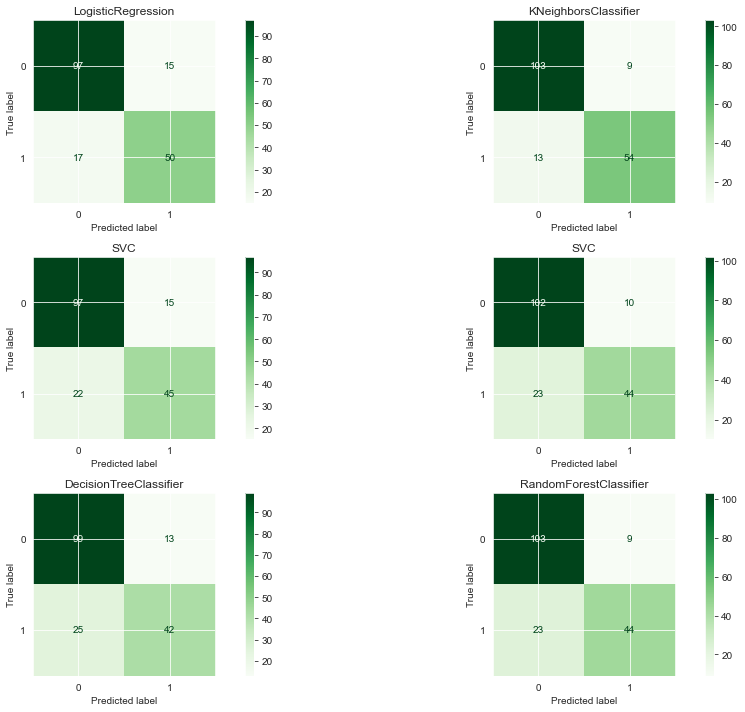

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,10))

for cls, ax in zip(models, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test, 
                          Y_test, 
                          ax=ax, 
                          cmap='Greens')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

# Variable Importance

In [23]:
#defining the testing data we want to use 
X = test_df.iloc[:, 1:6]
X.head()

,Pclass,Sex,Age,SibSp,Parch
0,3,1,2.0,0,0
1,3,0,2.0,1,0
2,2,1,3.0,0,0
3,3,1,1.0,0,0
4,3,0,1.0,1,1


<AxesSubplot:>

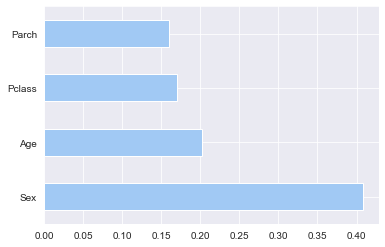

In [45]:
(pd.Series(model[4].feature_importances_, index= X.columns)
   .nlargest(4)
   .plot(kind='barh')) #https://stackoverflow.com/questions/44511636/plot-feature-importance-with-feature-names

<AxesSubplot:>

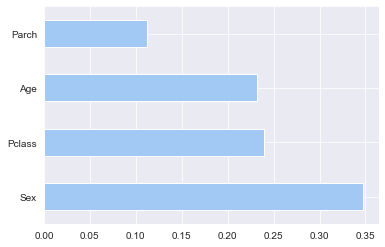

In [28]:
(pd.Series(model[5].feature_importances_, index=X.columns)
   .nlargest(4)
   .plot(kind='barh'))

In [25]:
# could move into a function
logistic = models[0]
result = logistic.predict(X)
logistic_prediction_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 
                                       'Result' : result})
#KNN prediction df
KNN = models[1]
result = KNN.predict(X)
KNN_prediction_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 
                       'Result' : result})
#SVM1 prediction df
SVM = models[2]
result = SVM.predict(X)
SVM_prediction_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 
                       'Result' : result})
#SVM2 prediction df
SVM2 = models[3]
result = SVM2.predict(X)
SVM2_prediction_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 
                        'Result' : result})
Tree = models[4]
result = Tree.predict(X)
tree_prediction_df = pd.DataFrame({'PassengerId': test_df['PassengerId'],
                                   'Result' : result})
#random forest prediction model
RF = models[5]
result = RF.predict(X)
RF_prediction_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Result' : result})
logistic_prediction_df

,PassengerId,Result
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
409,1301,1
411,1303,1
412,1304,1
414,1306,1


In [49]:
example_output_df # provided by Kaggle to compare

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
